# Homework Starter — Stage 10a: Linear Regression

Use this as a scaffold if your project data isn’t ready. Replace the synthetic data section with your dataset when possible.

In [34]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st
import statsmodels.api as sm

sns.set()
np.random.seed(7)

## 1) Synthetic data (replace with your project data when ready)
- Finance-flavored factors and asset excess return
- Includes a quadratic effect to motivate specification checks

In [35]:
n = 200
dates = pd.bdate_range(start="2024-02-01", periods=n)
mkt_excess = np.random.normal(0, 0.011, size=n)
size = np.random.normal(0, 0.008, size=n)
value = np.random.normal(0, 0.009, size=n)
momentum = np.random.normal(0, 0.006, size=n)

beta0, beta_mkt, beta_size, beta_value, beta_mom, beta_mom2 = 0.0001, 0.9, 0.25, -0.15, 0.35, 3.5
noise_scale = 0.0035 + 0.5*np.abs(mkt_excess)
eps = np.random.normal(0, noise_scale)
asset_excess = (
    beta0 + beta_mkt*mkt_excess + beta_size*size + beta_value*value + beta_mom*momentum
    + beta_mom2*(momentum**2) + eps
)
df = pd.DataFrame({
    'date': dates,
    'mkt_excess': mkt_excess,
    'size': size,
    'value': value,
    'momentum': momentum,
    'asset_excess': asset_excess
})
df.head()

,date,mkt_excess,size,value,momentum,asset_excess
0,2024-02-01,0.018596,-0.013467,-0.000540,0.000141,0.014832
1,2024-02-02,-0.005125,0.008120,0.007089,-0.006840,-0.008599
2,2024-02-05,0.000361,-0.011532,-0.012885,-0.011216,-0.009577
3,2024-02-06,0.004483,-0.010749,0.003905,-0.010685,0.000033
4,2024-02-07,-0.008678,-0.002893,0.001250,0.002779,-0.005750


## 2) Baseline model fit
Follow the steps; replace `df` with your project DataFrame when ready.

In [36]:
X = df[['mkt_excess','size','value','momentum']]
y = df['asset_excess']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
print(f'Baseline   R²={r2:.4f}  RMSE={rmse:.6f}')

Baseline   R²=0.3677  RMSE=0.008470


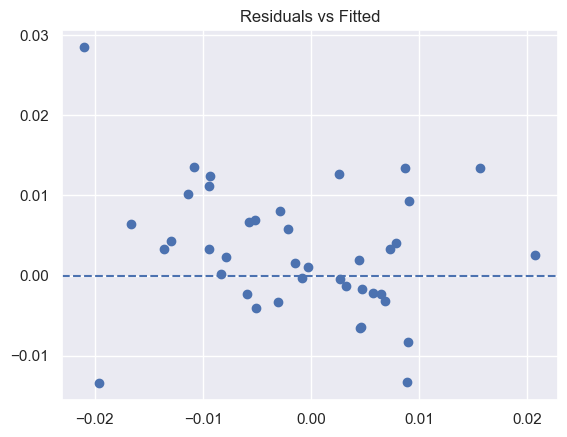

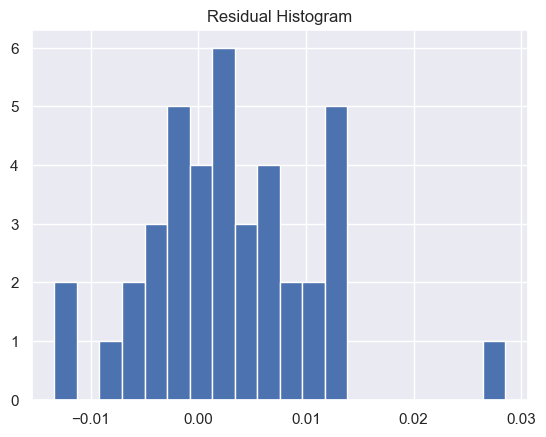

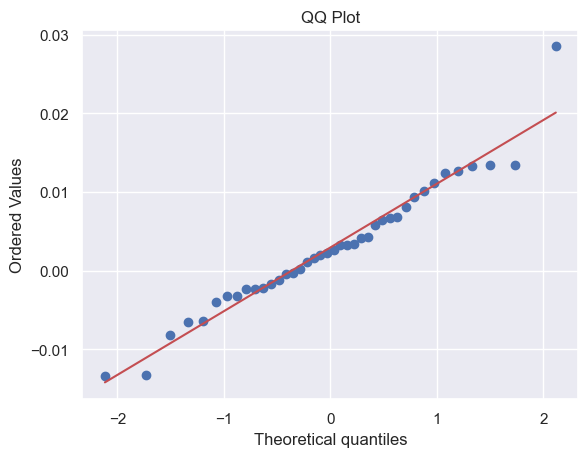

In [37]:
resid = y_test - y_pred
fitted = y_pred
plt.figure(); plt.scatter(fitted, resid); plt.axhline(0, ls='--'); plt.title('Residuals vs Fitted'); plt.show()
plt.figure(); plt.hist(resid, bins=20); plt.title('Residual Histogram'); plt.show()
plt.figure(); st.probplot(resid, dist='norm', plot=plt); plt.title('QQ Plot'); plt.show()

Text(0.5, 1.0, '*Residuals vs Observation:*  Independence ')

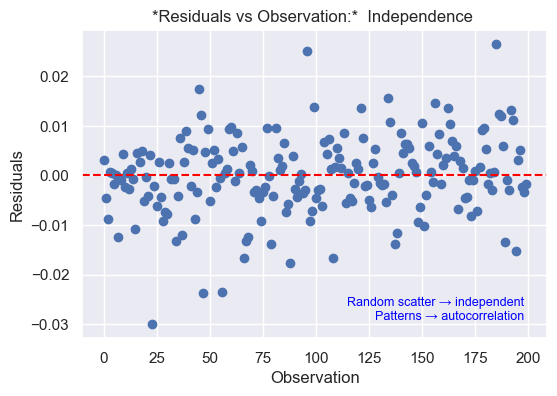

In [39]:
def plot_residual_autocorrelation(model, show_acf=True, ax=None):
    residuals = model.resid
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    if show_acf:
        sm.graphics.tsa.plot_acf(residuals, ax=ax)
        ax.set_title('Residual Autocorrelation')
        ax.text(0.95,0.05,'Spikes outside CI → dependence\nOtherwise → independent',
                transform=ax.transAxes, fontsize=9, ha='right', va='bottom', color='blue')
    else:
        ax.scatter(np.arange(len(residuals)), residuals)
        ax.axhline(0, color='red', linestyle='--')
        ax.set_xlabel('Observation')
        ax.set_ylabel('Residuals')
        ax.set_title('Residuals vs Observation')
        ax.text(0.95,0.05,'Random scatter → independent\nPatterns → autocorrelation',
                transform=ax.transAxes, fontsize=9, ha='right', va='bottom', color='blue')
    return ax
model = sm.OLS(y, sm.add_constant(X)).fit()
plot_residual_autocorrelation(model, show_acf=False)
plt.title('*Residuals vs Observation:*  Independence ')

## 3) Optional: Add a transformed feature
Add a polynomial or interaction if diagnostics suggest mis-specification.

In [26]:
df['momentum_sq'] = df['momentum']**2
X2 = df[['mkt_excess','size','value','momentum','momentum_sq']]
X2_train, X2_test = X2.iloc[:len(X_train)], X2.iloc[len(X_train):]
lr2 = LinearRegression().fit(X2_train, y_train)
y_pred2 = lr2.predict(X2_test)
r2_2 = r2_score(y_test, y_pred2)
rmse_2 = mean_squared_error(y_test, y_pred2)** 0.5
print(f'With x^2   R²={r2_2:.4f}  RMSE={rmse_2:.6f}')

With x^2   R²=0.3681  RMSE=0.008467


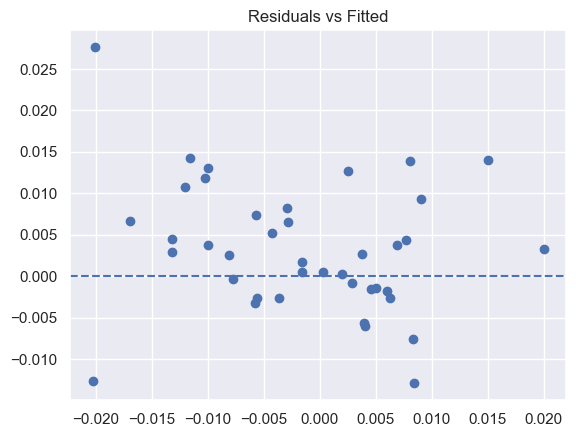

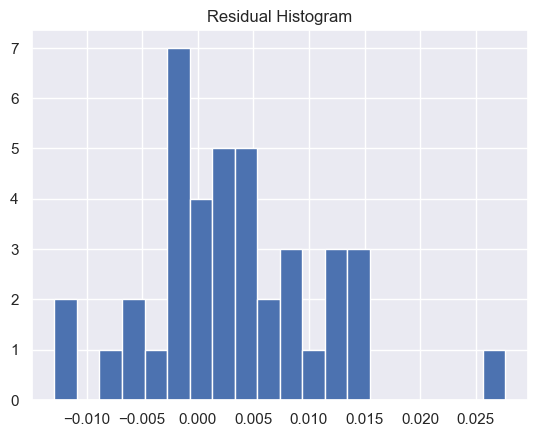

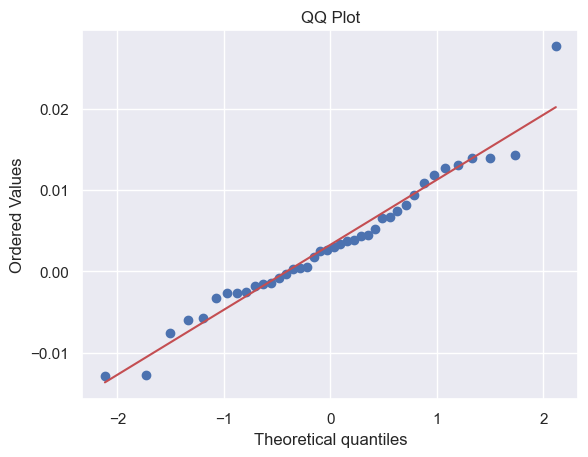

In [40]:
resid = y_test - y_pred2
fitted = y_pred2
plt.figure(); plt.scatter(fitted, resid); plt.axhline(0, ls='--'); plt.title('Residuals vs Fitted'); plt.show()
plt.figure(); plt.hist(resid, bins=20); plt.title('Residual Histogram'); plt.show()
plt.figure(); st.probplot(resid, dist='norm', plot=plt); plt.title('QQ Plot'); plt.show()


## 4) Interpretation (write your conclusions below)
- Linearity: Residuals vs Fitted plot indicates that residuals are approximately randomly scatter around 0 though it's slightly clustered around 0.01. Overall, there's no clear curvature, making linearity satisfied. 
- Homoscedasticity: Residuals vs Fitted plot shows no clear funnel trend, showing the data satisfied homoscedasticity( same variance).
- Normality: The values in QQ plot points on 45 degree line, suggesting assumption on normality of error are met. However, residual histogram are slighly left skewed, and that might need furthur inspection. 
- Independence: Since it's randomly scattered in the residuals vs obervation graph, it's fare to say the data is indepedent.
- Which model do you trust and why?: I dont' think there's clear improvement on clearity if i add a transformed feature. Hence, I'll stay with the original one.
- Next step you’d try: I think the data is on a good shape and ready to go. I'll probrabily try another fit model( log transformation as an exmaple) to make ensure better accuracy.  